In [1]:
import copy
import pywt
import math
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import talib as ta
import tensorflow as tf
from model import Company, StockLog, IndexLog, PerformanceLog
from model import start_engine
from datetime import date, datetime
from sklearn.preprocessing import MinMaxScaler
from utils import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

%matplotlib inline
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Read Stock Data

In [12]:
stock = 'ABC'
start = datetime.strptime('2018-06-01', '%Y-%m-%d').date()
finish = datetime.strptime('2019-05-30', '%Y-%m-%d').date()

In [13]:
engine = start_engine()
company = Company().query().get(stock)
stock_log = StockLog().query().filter(StockLog.company==company)
df = pd.read_sql(stock_log.statement, engine)
df.sort_values(by='date', inplace=True)
df.set_index('date', inplace=True)

# Read Fundamental Indicies

In [14]:
sectors = {'Consumer Discretionary': 'discretionary',
           'Consumer Staples': 'staples',
           'Energy': 'energy',
           'Financials': 'financials',
           'Health Care': 'healthcare',
           'Industrials': 'industrials',
           'Information Technology': 'infotech',
           'Materials': 'materials',
           'Telecommunication Services': 'telecom',
           'Utilities': 'utilities',
           'Real Estate': 'realestate'}
sectors_cpy = copy.deepcopy(sectors)
sectors_cpy.pop(company.sector)
sectors_cpy = set([sectors_cpy[sector] for sector in sectors_cpy])

index_log = IndexLog().query()
fi = pd.read_sql(index_log.statement, engine)
indicies = set(fi['index'])
indicies -= sectors_cpy

for idx in indicies:
    new = fi.loc[fi['index'] == idx]
    new = new.rename(columns={'value': idx})
    new.sort_values(by='date', inplace=True)
    new.set_index('date', inplace=True)
    new.drop(new.columns[[0]], axis=1, inplace=True)
    df = df.merge(new, how='outer', left_index=True, right_index=True)
df.rename(columns={sectors[company.sector]: 'sector'}, inplace=True)

# Clean Up

In [15]:
df.drop(df[df.opening == 0].index, inplace=True)
df.dropna(subset=['opening'], inplace=True)

In [16]:
df['prime'].interpolate(method='pad', inplace=True)
df['world'].interpolate(method='pad', inplace=True)
df['pacific'].interpolate(method='pad', inplace=True)
df['axvi'].interpolate(method='pad', inplace=True)
df['sector'].interpolate(method='pad', inplace=True)
df['aud_usd'].interpolate(method='pad', inplace=True)
df['twi'].interpolate(method='pad', inplace=True)

In [17]:
df.drop(df[df.index < start].index, inplace=True)
df.drop(df[df.index > finish].index, inplace=True)

# Transforming the Data

In [18]:
x = np.array(df.iloc[:, 3])
cA4, cD4, cD3, cD2, cD1 = pywt.wavedec(x, 'haar', level=4)
cA4 = pywt.threshold(cA4, np.std(cA4), mode="hard")
cD4 = pywt.threshold(cD4, np.std(cD4), mode="hard") 
cD3 = pywt.threshold(cD3, np.std(cD3), mode="hard") 
cD2 = pywt.threshold(cD2, np.std(cD2), mode="hard") 
cD1 = pywt.threshold(cD1, np.std(cD1), mode="hard") 
tx = pywt.waverec((cA4, cD4, cD3, cD2, cD1), 'haar')
df['dwt'] = tx
print('Signal noise: ', x.mean()/x.std())
print('Transform noise: ', tx.mean()/tx.std())

Signal noise:  5.153819965829348
Transform noise:  5.164624626727152


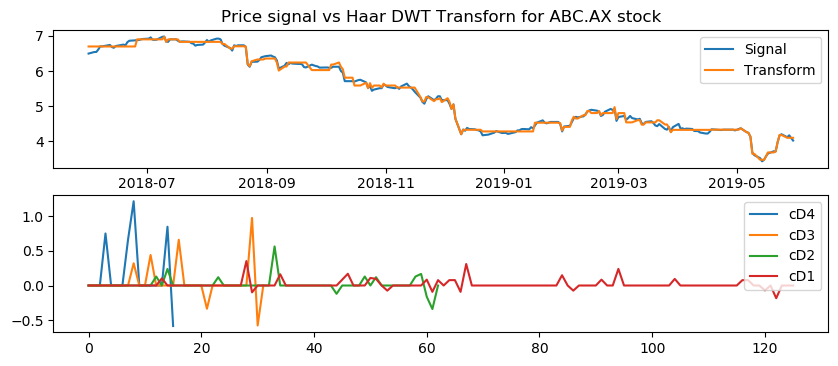

In [25]:
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(2, 1, 1)
plt.plot(df.index, x, label='Signal')
plt.plot(df.index, tx, label='Transform')
plt.title('Price signal vs Haar DWT Transforn for ABC.AX stock')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(cD4, label='cD4')
plt.plot(cD3, label='cD3')
plt.plot(cD2, label='cD2')
plt.plot(cD1, label='cD1')
plt.legend()
plt.savefig('dwt.png')
plt.show()

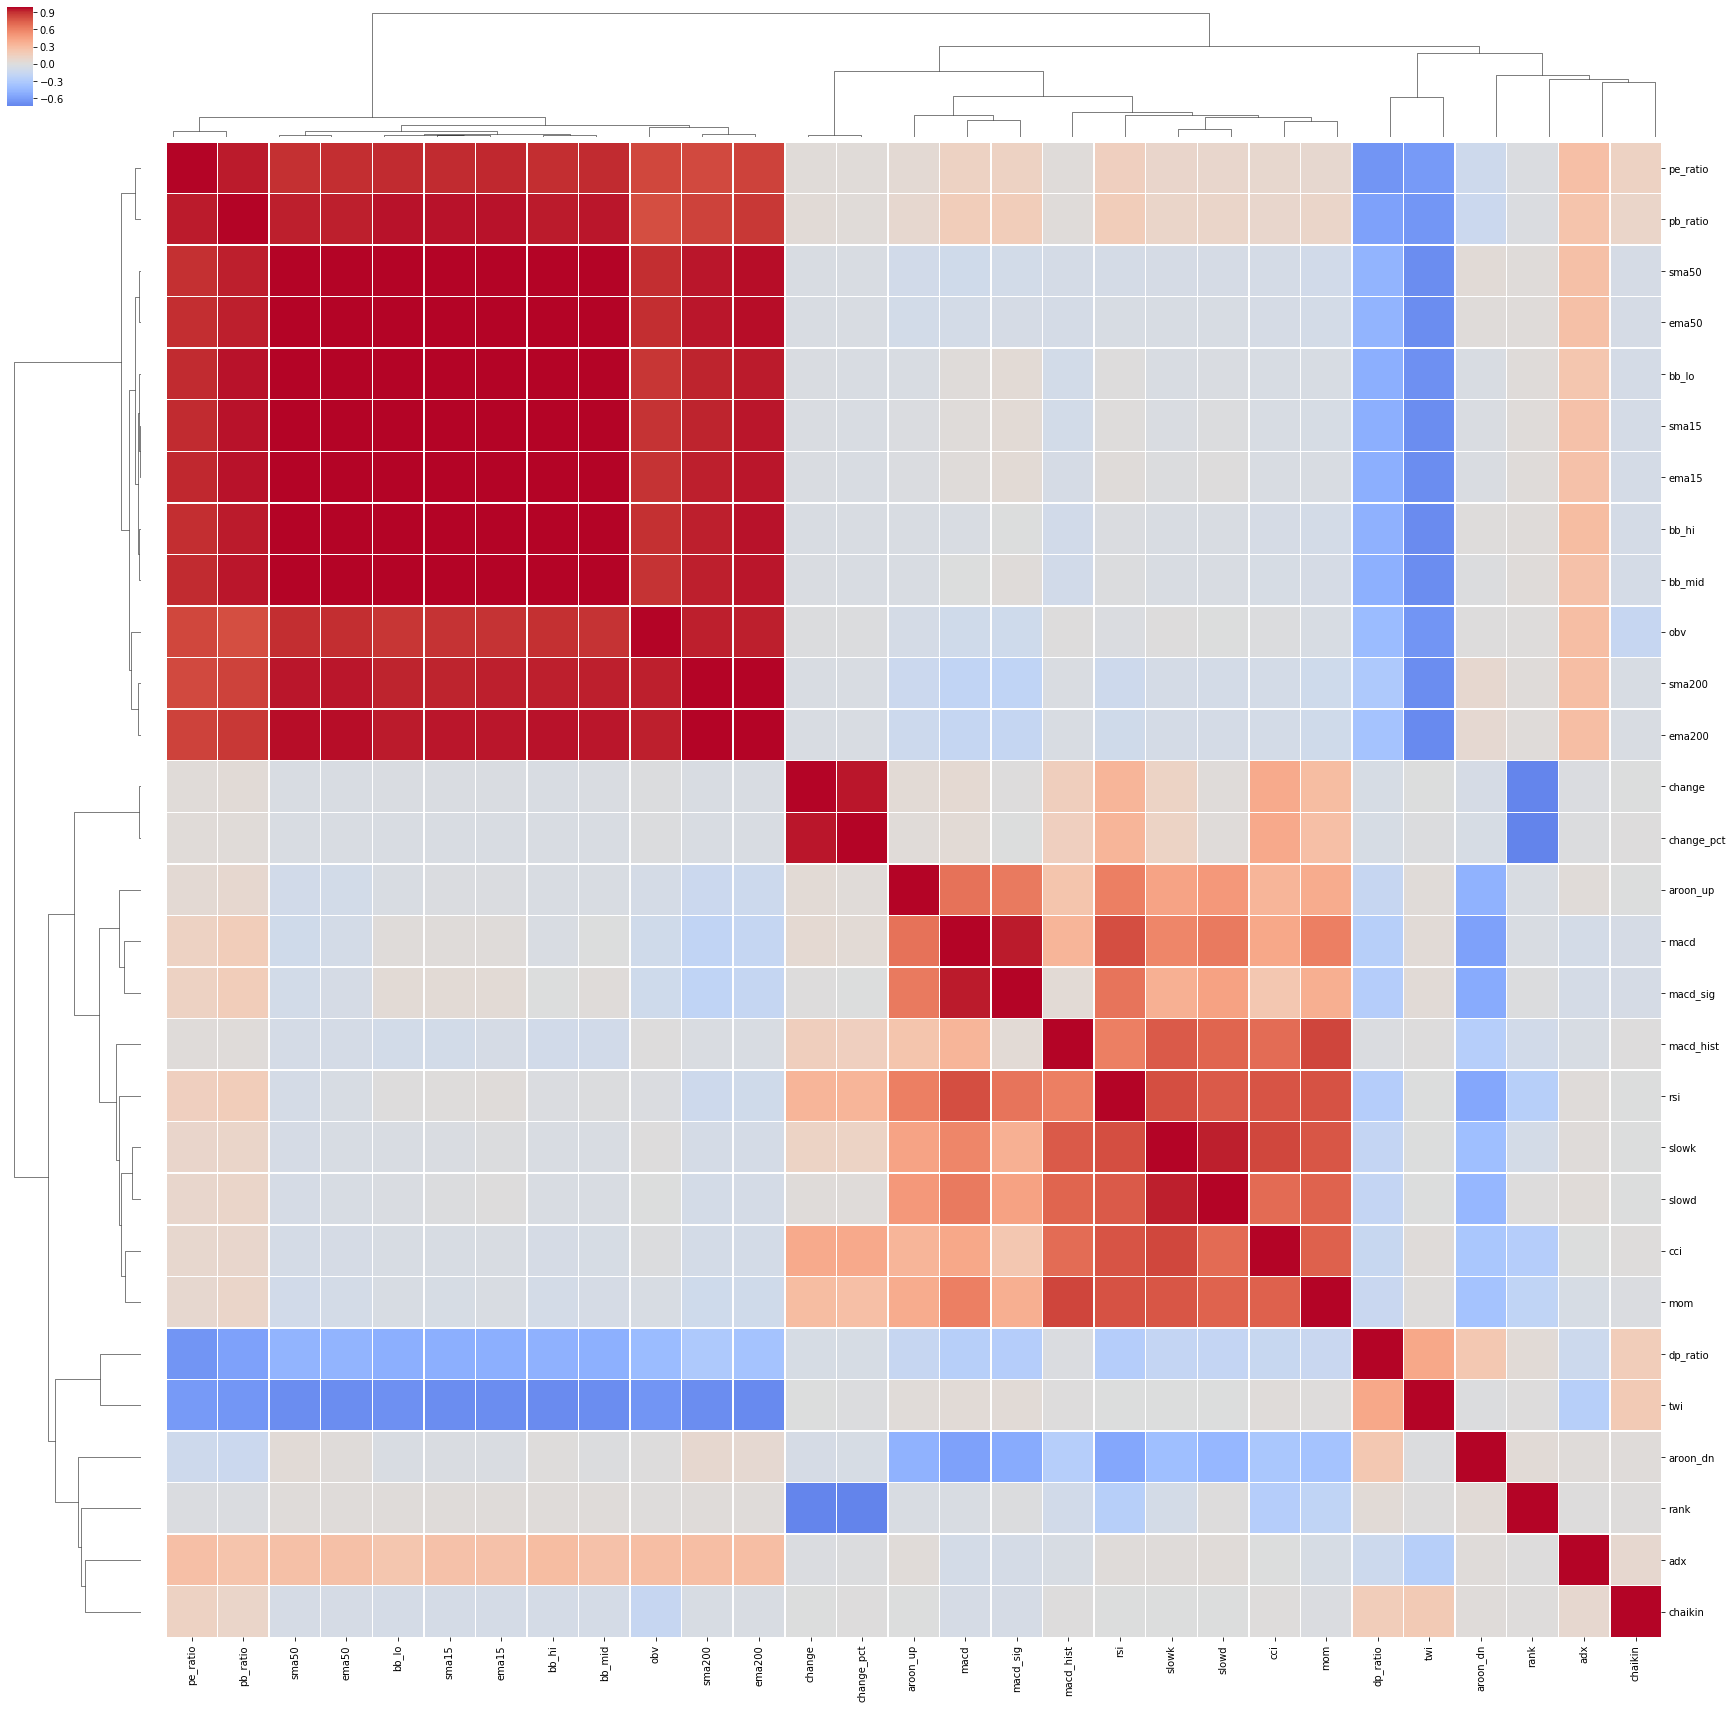

In [10]:
corr = df.iloc[:, 7:-8].corr()
plot = sns.clustermap(corr, cmap='coolwarm', center=0, square=True, linewidths=.5, figsize=(30, 30))
plot.savefig("clustermap.png")
plt.show()

# Predictor

In [11]:
df['dwt'] = df['dwt'].shift(-1)
df['closing'] = df['closing'].shift(-1)

In [12]:
df.drop(df.columns[[0, 1, 2, 3, 4, 5, 6, -13, -12, -10]], axis=1, inplace=True)
df.dropna(inplace=True)

In [1]:
df.to_parquet('abc.parquet')

NameError: name 'df' is not defined

In [120]:
df = pd.read_parquet('abc.parquet')

In [121]:
dataset = df.values

In [122]:
dataset.shape

(2376, 44)

In [123]:
# Data split
train_end = int(np.floor(0.8 * dataset.shape[0]))
train = dataset[:train_end, :]
valid = dataset[train_end:, :]

In [124]:
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

ValueError: could not convert string to float: 'ABC'

In [83]:
x_train = []
y_train = []
for i in range(60, len(train)):
    x_train.append(scaled_data[i-60:i, :-1])
    y_train.append(scaled_data[i, -1])

In [84]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [85]:
x_train.shape

(1840, 60, 34)

In [86]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

In [87]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=60, verbose=2)

Epoch 1/1
 - 7s - loss: 0.0149


In [88]:
inputs = df[len(df) - len(valid) - 60:].values

In [89]:
inputs.shape

(535, 35)

In [90]:
inputs = scaler.transform(inputs)

In [91]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i, :-1])
X_test = np.array(X_test)

In [92]:
X_test.shape

(475, 60, 34)

In [93]:
closing_price = model.predict(X_test)

In [94]:
closing_price.shape

(475, 1)

In [95]:
X_tmp = X_test[:, 0, :]

In [96]:
X_tmp.shape

(475, 34)

In [97]:
prediction = np.concatenate((X_tmp, closing_price), axis=1)

In [98]:
prediction.shape

(475, 35)

In [99]:
prediction = scaler.inverse_transform(prediction)

In [111]:
rms=np.sqrt(np.mean(np.power((valid[:, -1]-prediction[:, -1]),2)))

In [112]:
rms

0.46554243377505916

In [113]:
prediction.shape

(475, 35)

In [114]:
train_end = int(np.floor(0.8 * dataset.shape[0]))
train_end

1900

In [115]:
train = df[:train_end]
valid = df[train_end:]

In [116]:
valid['Predictions'] = prediction[:, -1]

In [117]:
valid.columns

Index(['sma15', 'sma50', 'sma200', 'ema15', 'ema50', 'ema200', 'macd',
       'macd_sig', 'macd_hist', 'bb_hi', 'bb_mid', 'bb_lo', 'slowk', 'slowd',
       'rsi', 'adx', 'cci', 'aroon_dn', 'aroon_up', 'chaikin', 'obv', 'mom',
       'pe_ratio', 'dp_ratio', 'pb_ratio', 'change_pct', 'twi', 'sector',
       'pacific', 'aud_usd', 'axvi', 'asx200', 'world', 'prime', 'dwt',
       'Predictions'],
      dtype='object')

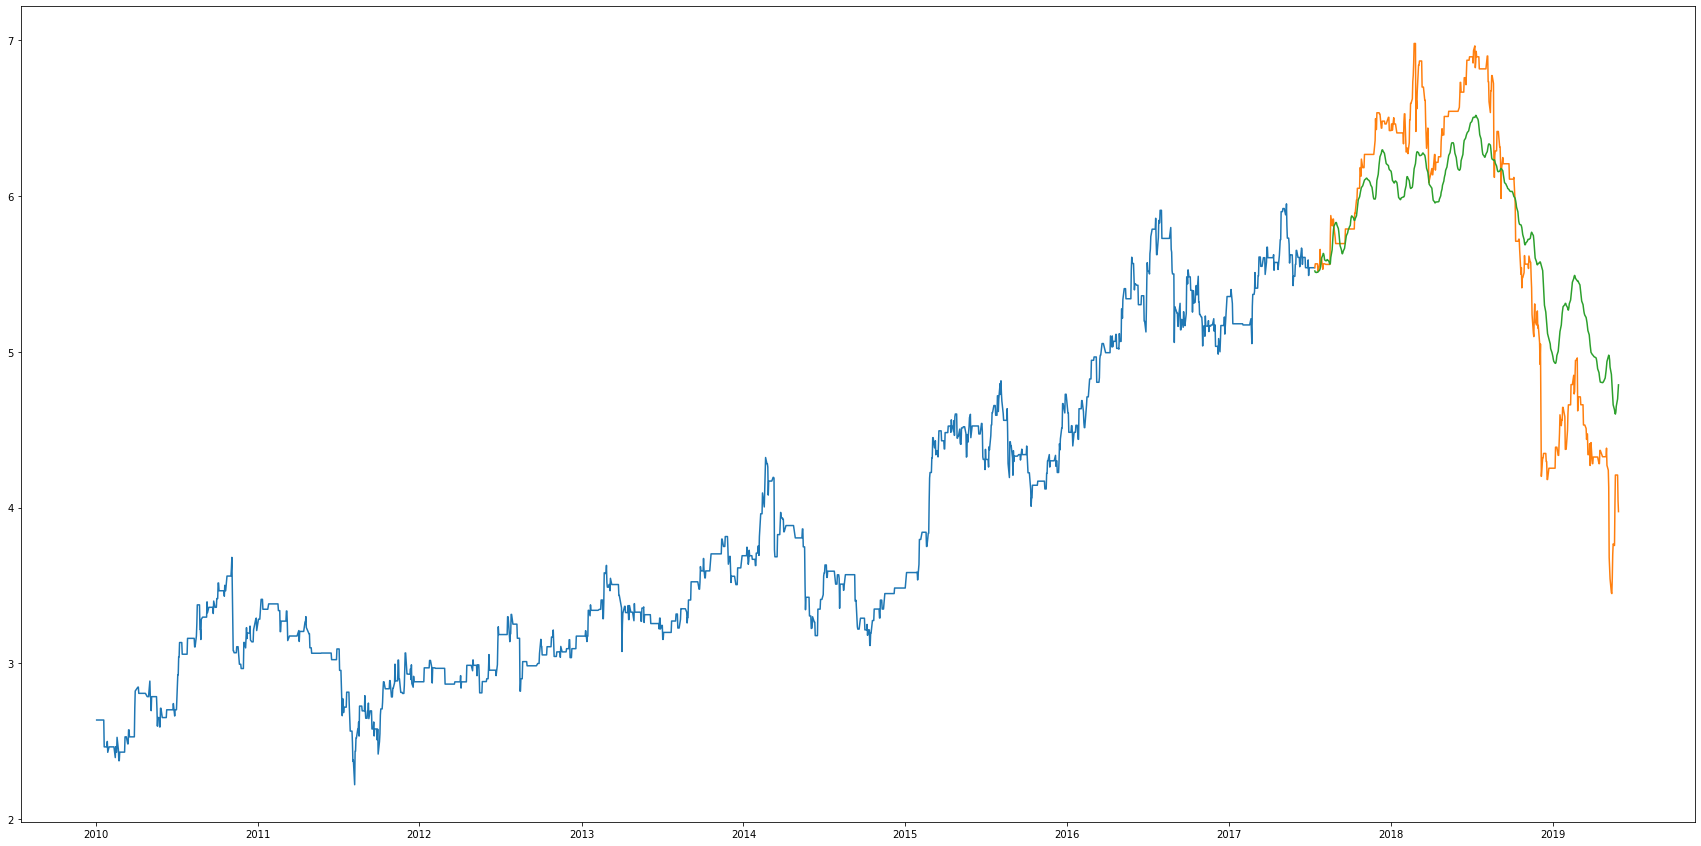

In [118]:
plt.figure(figsize=(30,15)) 
plt.plot(train['dwt'])
plt.plot(valid[['dwt', 'Predictions']])